In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
import plotly.graph_objects as go
import plotly.graph_objects as px
import mpld3

In [132]:
!pip install mpld3

In [133]:
%run data_pipeline.ipynb

########## Data pipeline ##########

Preparing CMU data
379 movies shared both name and release year, dropping
314 movies had actors with the same name, dropping

Merging Oscar dataset, after merge:
Number of different Oscar nominated movies in dataset: 952 in total 63968 different movies
Number of different Oscar nominated actors in dataset: 801 in total 134907 different actors
Number of Oscar nominated rows: 1443

Merging IMDb dataset, after merge:
Number of movies with ratings: 36758
Oscar nominated movies with rating: 939
Number of rows in data before cleaning:  443504
Number of rows in data after cleaning:  23819
Number of rows where age is < 0: 7 . Dropping these rows

FINAL STATE OF DATA
Number of rows:  23812
Number of different Oscar nominated movies in dataset: 394 in total 5987 different movies
Number of different Oscar nominated actors in dataset: 284 in total 2959 different actors
Number of Oscar nominated rows: 519
Processing done, dataset written to cache/data.csv


In [134]:
# Read data
df = pd.read_csv('cache/data.csv', sep=',', index_col=0)
unclean_df = pd.read_csv('cache/unclean_data.csv', sep=',', index_col=0)

In [135]:
df.head()

,title,box_office_revenue,runtime,languages,countries,genres,movie_identifier,actor_gender,actor_height,actor_ethnicity,...,identifier,category,winner,oscar_nominated,year,average_rating,number_of_votes,number_of_movies_starred_in,average_rating_previous_movies,average_box_office_revenue_previous_movies
140029,Down to You,24419914,92,"['French Language', 'English Language']",['United States of America'],"['Romantic comedy', 'Romance Film', 'Drama', '...",down to you_2000,M,1.88,/m/0xnvg,...,down to you_2000_adam carolla,NaN,NaN,False,2000,5.0,15878,1,2.500000,1.220996e+07
60320,The Bible: In The Beginning,34900023,171,['English Language'],"['United States of America', 'Italy']","['Christian film', 'Drama', 'Epic', 'World cin...",the bible in the beginning_1966,M,1.85,/m/03bkbh,...,the bible in the beginning_1966_richard harris,NaN,NaN,False,1966,6.2,6385,1,3.100000,1.745001e+07
389034,Hawaii,34562222,161,['English Language'],['United States of America'],"['Period piece', 'Roadshow theatrical release'...",hawaii_1966,M,1.85,/m/03bkbh,...,hawaii_1966_richard harris,NaN,NaN,False,1966,6.5,3708,1,6.350000,3.473112e+07
130002,Camelot,31102578,178,['English Language'],['United States of America'],"['Costume drama', 'Musical', 'Roadshow theatri...",camelot_1967,M,1.85,/m/03bkbh,...,camelot_1967_richard harris,NaN,NaN,False,1967,6.6,7624,2,6.433333,3.352161e+07
182566,Caprice,4075000,95,['English Language'],['United States of America'],"['Romantic comedy', 'Crime Fiction', 'Mystery'...",caprice_1967,M,1.85,/m/03bkbh,...,caprice_1967_richard harris,NaN,NaN,False,1967,5.5,1761,3,6.200000,2.615996e+07


## **Actor Network Analysis**

In this section we dive into each actors network. How many relationships does a oscar nominated actor have? How many does an oscar winner have? Does this correlate and does non-nominated actors have fewer relationships?

(note; A relationship is defined as starred in the same movie as another actor)

In [136]:
df_movies = df
oscar_nominated_df = df[df['oscar_nominated']==True]

First we take a look at all actors:

In [137]:
# Creating a graph
G = nx.Graph()

# Adding all actors as nodes
for _, row in df_movies.iterrows():
    G.add_node(row['actor_identifier'], oscar_nominated=row['oscar_nominated'])


# Grouping, and for each group add the each combination of actors as an edge
for movie, group in df_movies.groupby('title'):
    actors = group['actor_identifier'].tolist()
    for actor1, actor2 in combinations(actors, 2):
        if G.has_edge(actor1, actor2):
            # Adding an edge 
            G[actor1][actor2]['movies'].append(movie)
        else:
            # If the edge already exists, adding the movie to the list of movies for that edge. 
            G.add_edge(actor1, actor2, movies=[movie])


In [138]:
# Now we add the degree of each node in two lists based on if they are nominated 
# or not such that we can calculate the average degree of both groups. 
nominated_nodes = []
not_nodes = []
degree_dict = dict(G.degree())
for node, degree in degree_dict.items():
    nominated = G.nodes[node]['oscar_nominated']
    if nominated: 
        nominated_nodes.append(G.degree(node))
    else: 
        not_nodes.append(G.degree(node))

print('Mean edge count for not nominated actors: ', np.round(np.mean(not_nodes),1))
print('Mean edge count for nominated actors: ', np.mean(nominated_nodes))

Mean edge count for not nominated actors:  37.2
Mean edge count for nominated actors:  72.8


Nominated actors has almost 2x the relationsships compared to not nominated. We look into this further by comparing number of movie performances for not nominated and not nominated actors. 

In [139]:
# Defining values for plot. 
temp_df = df[['actor_identifier','oscar_nominated']].groupby('actor_identifier').agg('max').reset_index()
df_with_nominated_status = df.merge(temp_df, on='actor_identifier', how='outer')

oscar_nominated_actors = df_with_nominated_status[df_with_nominated_status['oscar_nominated_y'] == True]
oscar_nominated_actors = oscar_nominated_actors[['actor_identifier', 'number_of_movies_starred_in']].groupby('actor_identifier').agg('max')

not_nominated_actors = df_with_nominated_status[df_with_nominated_status['oscar_nominated_y'] == False]
not_nominated_actors = not_nominated_actors[['actor_identifier', 'number_of_movies_starred_in']].groupby('actor_identifier').agg('max')
oscar_nominated_actors.mean()
not_nominated_actors.mean()

number_of_movies_starred_in    5.96785
dtype: float64

In [140]:
# Defining values for plot. 
mean_relationships_nominated = np.mean(nominated_nodes)
mean_relationships_not_nominated = np.mean(not_nodes)

In [141]:
# Plotting 
x = ['Relationships', 'Movie performances']
 
plot = px.Figure(data=[px.Bar(
    name = 'Nominated',
    x = x,
    y = [mean_relationships_nominated,oscar_nominated_actors.mean().values[0]], 
     marker_color='blue'
   ),
    px.Bar(
    name = 'Not nominated',
    x = x,
    y = [mean_relationships_not_nominated, not_nominated_actors.mean().values[0]], 
    marker_color = 'red'
    )
]
)    

plot.update_layout(
    title="Relationships and Performances for nominated and not nominated actors",
    yaxis_title="Number of movies or Relationships",
)

plot.write_html('network_analysis.html', full_html=False, include_plotlyjs='cdn')
plot.show()

Actors that are nominated have significantly more relationships compared to not nominted relationships, while nr. of movie performances are relatively similar. 

In [142]:
G = nx.Graph()
for movie, group in oscar_nominated_df.groupby('movie_identifier'):
    actors = group['actor_identifier'].tolist()
    for actor1, actor2 in combinations(actors, 2):
        if G.has_edge(actor1, actor2):
            G[actor1][actor2]['movies'].append(movie)
        else:
            G.add_edge(actor1, actor2, movies=[movie])

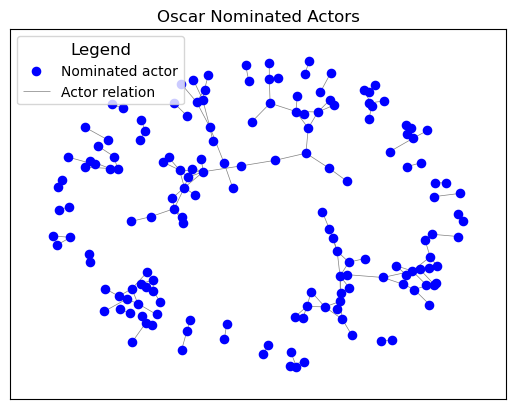

In [143]:
pos = nx.spring_layout(G, k=0.15, iterations=50) 
nx.draw_networkx_nodes(
    G, pos,
    node_color='blue', 
    node_size=35,
    label='Nominated actor'  
)

nx.draw_networkx_edges(
    G, pos,
    width=0.5,
    edge_color='gray', 
    label = 'Actor relation'
)


plt.legend
plt.title('Oscar Nominated Actors')
plt.legend(
    loc='upper left',  
    title="Legend",   
    fontsize='10',
    title_fontsize='12'
)
mpld3.save_html(plt.gcf(), "network_graph.html")

It seems like all nominated actors have atleast one relationship with one other nominated actor. 

TEXT NETWORK ANALYSIS: 

What makes a great movie is seldom a single performance, it often an ensemble of great performances enhancing each other. Hence we make a deep dive into the actor relationships with other actors. We define a relationship as having performed in the same movie as another actor, i.e. actors will be nodes and shared performances between actors are edges in a graph. It is however not useful plotting the graph of all actors as it has over 23 000 nodes. We instead count the number of relationships for nominated and not nominated actors which turn out to 72.8 and 37.2 respectively. Nominated actors have this number of relationships while on average having stared in 8.9 movies while not nominated actors have on average starred in 7.9 movies. From this we see three options: 1. Nominated actors perofmr in movies with more actors, creatingmore relationships per movie starred in. 2. Nominated actors are in more popular movies where more actors are registered and hence in the dataset. 3. TBD

Additionally, it appears that all nominated actors have a relationship to atleas another oscar nominated actor. This enforces the hypothesis that great performances are not stand-alone but rather enforced by other performances. 